## Downloading kaggle data
### Save kaggle.json from kaggle API settings into drive path

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import API key from drive to colab env
!mkdir ~/.kaggle

# Save kaggle.json from kaggle API settings into drive path

!cp /content/drive/MyDrive/Uni/sem1/dltf/kaggle.json ~/.kaggle

# Install kaggle API
!pip install -q kaggle

# Add necessary permission
!chmod 600 ~/.kaggle/kaggle.json

# Create dataset folder and download data
!mkdir dataset && rm -r sample_data
!cd dataset && kaggle competitions download -c g-research-crypto-forecasting

# Extract the train.csv
!unzip /content/dataset/train.csv.zip

Mounted at /content/drive
  0% 0.00/660k [00:00<?, ?B/s]
100% 660k/660k [00:00<00:00, 90.7MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 58.9kB/s]
  0% 0.00/406 [00:00<?, ?B/s]
100% 406/406 [00:00<00:00, 375kB/s]
 87% 89.0M/103M [00:01<00:00, 69.0MB/s]
100% 103M/103M [00:01<00:00, 81.9MB/s] 
 99% 1.01G/1.02G [00:09<00:00, 143MB/s]
100% 1.02G/1.02G [00:09<00:00, 110MB/s]
  0% 0.00/444 [00:00<?, ?B/s]
100% 444/444 [00:00<00:00, 378kB/s]
  0% 0.00/5.78k [00:00<?, ?B/s]
100% 5.78k/5.78k [00:00<00:00, 5.79MB/s]
Archive:  /content/dataset/train.csv.zip
  inflating: train.csv               


## source/credits : **https**://www.kaggle.com/metathesis/torch-lstm-baseline-training-updated/notebook

## Load and preprocess the data

Training data end date : 31/5/21  
Testing beginning date : 1/6/21


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import datasets, models, transforms

from tqdm import tqdm


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [ ]:
%%time
df = pd.read_csv('train.csv')

CPU times: user 23.8 s, sys: 6.05 s, total: 29.8 s
Wall time: 29.8 s


## dont run the following block

In [ ]:
# Convert UNIX timetamps 
df['Time'] = pd.to_datetime(df['timestamp'], unit='s')
# Creating bitcoin dataset
btc = df[df['Asset_ID']==1]

# Drop old index
btc = btc.reset_index(drop=True)

# Set timestamp as index
btc.set_index('timestamp', inplace = True)

# Drop useless fetures
btc = btc.drop(['Asset_ID','Open', 'High', 'Low', 'Time'], 1)

# Drop NANs from 'Target' variable
btc['Target'].fillna(method='pad', inplace =True)

# Reindex with stepsize = 60 ????
btc  = btc.reindex(range(btc.index[0], btc.index[-1],60), method='pad')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
train = btc[btc.index< 1622505660].copy().reset_index(drop=True)
test = btc[btc.index>1622505660].copy().reset_index(drop=True)


## Run from here

In [ ]:
#Change the nrows to however many samples youd like, better results observed with low nrows value
df_train = pd.read_csv('train.csv', nrows=100000)
df_train.dropna(axis = 0, inplace = True)

df_train.shape

NameError: ignored

In [ ]:
training_data, validation_data = train_test_split(df_train, test_size = 0.2, shuffle = False)

In [ ]:
print(f"Training data size: {training_data.shape}",
      f"Validation data size: {validation_data.shape}")

Training data size: (38817, 10) Validation data size: (9705, 10)


## Hyperparameter tuning


In [ ]:
# Num of epochs
epochs = 10




# Features to consider
features = ['Close','High', 'Low', 'Open', 'VWAP', 'Volume']
num_features = len(features)
target = 'Target'

batch_size = 6

window_size = 60

dropout = 0.2

hidden_size = 100
output_size = 1
directions = 1
num_layers = 5

state_dim = num_layers*directions, batch_size, hidden_size

learning_rate = 0.00001



## Dataset OOP

In [ ]:
class CreateDataset(Dataset):

    def __init__(self, csv, window_size, features, target):
      self.csv = csv
      self.window_size = window_size
      self.features = features
      self.target = target
      self.length = len(csv)

      self.stats = self.create_windows()

    def create_windows(self):
      new_dataset = []
      for idx in range(self.length - self.window_size):
        x = self.csv[idx:idx + self.window_size][self.features].values
        y = self.csv[idx + self.window_size:idx + self.window_size +1][self.target].values
        new_dataset.append((x,y))
      return new_dataset

    def __len__(self):
      return len(self.stats)
    
    def __getitem__(self, idx):
      return self.stats[idx]


In [ ]:
params = {'batch_size': batch_size,
          'shuffle': False,
          'drop_last': True, # Disregard last incomplete batch
          'num_workers': 2}
          

# Instantiate dataset and data loader
training_ds = CreateDataset(training_data, window_size, features,  target)
training_dl = DataLoader(training_ds, **params)

validation_ds = CreateDataset(validation_data, window_size, features, target)
validation_dl = DataLoader(validation_ds, **params)


## Model definition

In [ ]:
#Setting torch to use cuda..make sure to go to Runtime>Change runtime type>hardware accelerator>gpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Setting the seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

device


device(type='cuda', index=0)

In [ ]:
class LSTM(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, directions= 1):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.directions = directions

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(hidden_size, output_size)

  def init_hidden_layer(self, batch_size):
    state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
    return(torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device)) 

  def forward(self, x, states):
    x, (h,c) = self.lstm(x, states)
    out = self.linear(x)
    return out, (h,c)

## Instantiating model

In [ ]:
model = LSTM(num_features, hidden_size, num_layers, output_size, dropout).to(device)
print(num_features, hidden_size, num_layers, output_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr = learning_rate, weight_decay= 0.01)

6 100 5 1 0.2


In [ ]:
def save_checkpoint(epoch, min_val_loss, model_state, opt_state):
  print(f"New minimum reached at epoch #{epoch + 1}, saving model state...")
  checkpoint = {
    'epoch': epoch + 1,
    'min_val_loss': min_val_loss,
    'model_state': model_state,
    'opt_state': opt_state,
  }
  torch.save(checkpoint, "./model_state.pt")


def load_checkpoint(path, model, optimizer):
    # load check point
    checkpoint = torch.load(path)
    min_val_loss = checkpoint["min_val_loss"]
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["opt_state"])
    return model, optimizer, checkpoint["epoch"], min_val_loss
 

In [ ]:
#refer kaggle notebook for better documentation
def training(model, epochs, validate_every=2):

  training_losses = []

  validation_losses = []
  min_validation_loss = np.Inf

  model.train()

  for epoch in tqdm(range(epochs)):

    states = model.init_hidden_layer(batch_size)
    running_training_loss = 0.0

    for idx, (x_batch, y_batch) in enumerate(training_dl):

      x_batch = x_batch.float().to(device)
      y_batch = y_batch.float().to(device)

      states = [state.detach() for state in states]

      optimizer.zero_grad()

      output, states = model(x_batch, states)

      loss = criterion(output[:,-1,:], y_batch)
      loss.backward()
      running_training_loss += loss.item()

      torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
      optimizer.step()
    training_losses.append(running_training_loss/len(training_dl))

    if epoch % validate_every == 0:
      model.eval()
      validation_states = model.init_hidden_layer(batch_size)
      running_validation_loss = 0.0

      for idx, (x_batch, y_batch) in enumerate(validation_dl):
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        validation_states = [state.detach() for state in validation_states]
        output, validation_states = model(x_batch, validation_states)
        validation_loss = criterion(output[:,-1,:], y_batch)
        running_validation_loss += validation_loss.item()
    validation_losses.append(running_validation_loss/len(validation_dl))
    model.train()

    is_best = running_validation_loss/len(validation_dl) < min_validation_loss

    if is_best:
      min_validation_loss = running_validation_loss / len(validation_dl)
      save_checkpoint(epoch + 1, min_validation_loss, model.state_dict(), optimizer.state_dict())

  epoch_count = range(1, len(training_losses) + 1)
  plt.plot(epoch_count, training_losses, 'r--')
  plt.legend(['Training Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  val_epoch_count = range(1, len(validation_losses) + 1)
  plt.plot(val_epoch_count, validation_losses, 'b--')
  plt.legend(['Validation loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  print(validation_losses)
  print(training_losses)


 10%|█         | 1/10 [02:31<22:41, 151.33s/it]

New minimum reached at epoch #2, saving model state...


 30%|███       | 3/10 [07:19<17:07, 146.72s/it]

New minimum reached at epoch #4, saving model state...


 50%|█████     | 5/10 [12:06<12:08, 145.68s/it]

New minimum reached at epoch #6, saving model state...


100%|██████████| 10/10 [23:42<00:00, 142.28s/it]


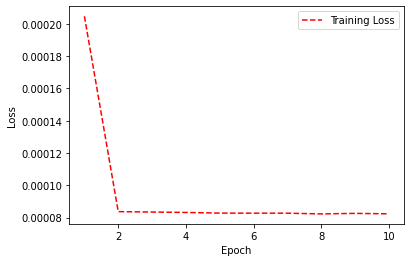

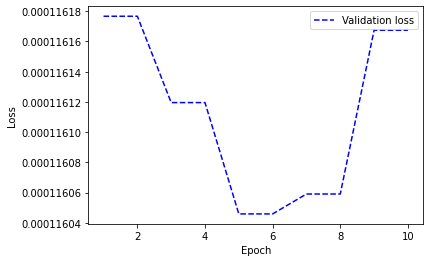

[0.00011617668361483779, 0.00011617668361483779, 0.00011611955885416217, 0.00011611955885416217, 0.00011604591037485588, 0.00011604591037485588, 0.0001160590873702412, 0.0001160590873702412, 0.00011616743740490028, 0.00011616743740490028]
[0.00020461742506800272, 8.370352604966308e-05, 8.346455131947095e-05, 8.320231658253675e-05, 8.280278246555961e-05, 8.27418244913919e-05, 8.273365228144517e-05, 8.229315966672555e-05, 8.262154302742621e-05, 8.234875594397317e-05]


In [ ]:
training(model, 10)
